In [1]:
import importlib
from typing import Tuple
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import json
import sys
import os

sys.path.insert(1, '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector')
print(sys.path)

import kad.visualization.visualization as visualization
import kad.kad_utils.kad_utils as kad_utils
import kad.models_evaluation.models_evaluator as models_evaluator
import kad.model_selector.model_selector as model_selector
from kad.model import i_model, autoencoder_model, hmm_model, lstm_model
from kad.model import sarima_model
from sklearn.model_selection import train_test_split

models_evaluator = importlib.reload(models_evaluator)

kad_utils.customize_matplotlib()

['/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/notebooks', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/IPython/extensions', '/home/maciek/.ipython']


In [2]:
SARIMA_KEY: str = "SARIMA"
AUTOENCODER_KEY: str = "autoencoder"
HMM_KEY: str = "HMM"
LSTM_KEY: str = "LSTM"

ACC_KEY: str = "accuracy"
VALID_ERR_KEY: str = "valid_err"
PREC_KEY: str = "precision"
RECALL_KEY: str = "recall"
AUROC_KEY: str = "auroc"

CUSTOM_KEY: str = "total"
CUSTOM_ACC_KEY: str = "accuracy component"
CUSTOM_COLL_KEY: str = "collective component"
CUSTOM_PREC_KEY: str = "precision component"

In [3]:

def downsampling_func(x: pd.DataFrame):
    """
    Values column is replaced with a mean, and labels are replaced by True if any of the labels
    in the original df was True
    :param x: part of dataframe to squash to one row
    :return: squashed pandas Series
    """
    values = x["value"].mean()

    labels = (x[kad_utils.GROUND_TRUTH_COLUMN]).any()

    return pd.Series([values, labels], index=["value", kad_utils.GROUND_TRUTH_COLUMN])

In [4]:
def perform_classical_evaluation(valid_err: float, evaluation_df: pd.DataFrame) -> dict:
    visualization.visualize(evaluation_df, metric_name="value")

    evaluator = models_evaluator.ModelsEvaluator(df=evaluation_df)

    print("Valid err: ", valid_err)
    print("Accuracy: ", evaluator.get_accuracy())
    print("Avg precision: ", evaluator.get_average_precision())
    print("Recall: ", evaluator.get_recall_score())
    print("AU ROC: ", evaluator.get_auroc())

    return {ACC_KEY: evaluator.get_accuracy(),
            # VALID_ERR_KEY: valid_err,
            PREC_KEY: evaluator.get_average_precision(),
            RECALL_KEY: evaluator.get_recall_score(),
            AUROC_KEY: evaluator.get_auroc()}


In [5]:
def perform_customized_evaluation(valid_err: float, evaluation_df: pd.DataFrame) -> dict:
    visualization.visualize(evaluation_df, metric_name="value")

    evaluator = models_evaluator.ModelsEvaluator(df=evaluation_df)

    print("Customized score: ", evaluator.get_customized_score())
    return {
        CUSTOM_KEY: evaluator.get_customized_score(),
        CUSTOM_ACC_KEY: evaluator.calculate_accuracy_scoring_component(),
        CUSTOM_COLL_KEY: evaluator.calculate_collective_scoring_component(),
        CUSTOM_PREC_KEY: evaluator.calculate_precision_scoring_component()
    }

In [6]:
def evaluate_sarima(p_preprocessed_df: pd.DataFrame) -> Tuple[float, pd.DataFrame]:
    values_df = p_preprocessed_df[["value"]]
    tsa = model_selector.ModelSelector(values_df)
    dominant_freq = tsa.calculate_dominant_frequency()

    model: i_model.IModel = sarima_model.SarimaModel(order=(0, 0, 0), seasonal_order=(1, 0, 1, dominant_freq))

    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    valid_err = model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 18
    for i in range(0, len(test_df), samples_to_predict):
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    return valid_err, results_df.loc[test_df.index & results_df.index]

In [7]:
def evaluate_autoencoder(p_preprocessed_df: pd.DataFrame) -> Tuple[float, pd.DataFrame]:
    model: i_model.IModel = autoencoder_model.AutoEncoderModel(time_steps=12)

    values_df = p_preprocessed_df[["value"]]
    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    valid_err = model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 60
    for i in range(0, len(test_df), samples_to_predict):
        if len(test_df.iloc[i:i + samples_to_predict]) < samples_to_predict:
            break
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    return valid_err, results_df.loc[test_df.index & results_df.index]

In [8]:
def evaluate_hmm(p_preprocessed_df: pd.DataFrame) -> Tuple[float, pd.DataFrame]:
    model: i_model.IModel = hmm_model.HmmModel()

    values_df = p_preprocessed_df[["value"]]
    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    valid_err = model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 5
    for i in range(0, len(test_df), samples_to_predict):
        if len(test_df.iloc[i:i + samples_to_predict]) < samples_to_predict:
            break
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    return valid_err, results_df.loc[test_df.index & results_df.index]

In [9]:
def evaluate_lstm(p_preprocessed_df: pd.DataFrame) -> Tuple[float, pd.DataFrame]:
    model: i_model.IModel = lstm_model.LstmModel(time_steps=12)

    values_df = p_preprocessed_df[["value"]]
    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    valid_err = model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 25
    for i in range(0, len(test_df), samples_to_predict):
        if len(test_df.iloc[i:i + samples_to_predict]) < samples_to_predict:
            break
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    return valid_err, results_df.loc[test_df.index & results_df.index]

after reading csv
after reading csv
after reading csv
after reading csv


<ipython-input-6-17537966d50a>:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return valid_err, results_df.loc[test_df.index & results_df.index]
<ipython-input-6-17537966d50a>:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return valid_err, results_df.loc[test_df.index & results_df.index]
<ipython-input-6-17537966d50a>:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return valid_err, results_df.loc[test_df.index & results_df.index]
<ipython-input-6-17537966d50a>:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a

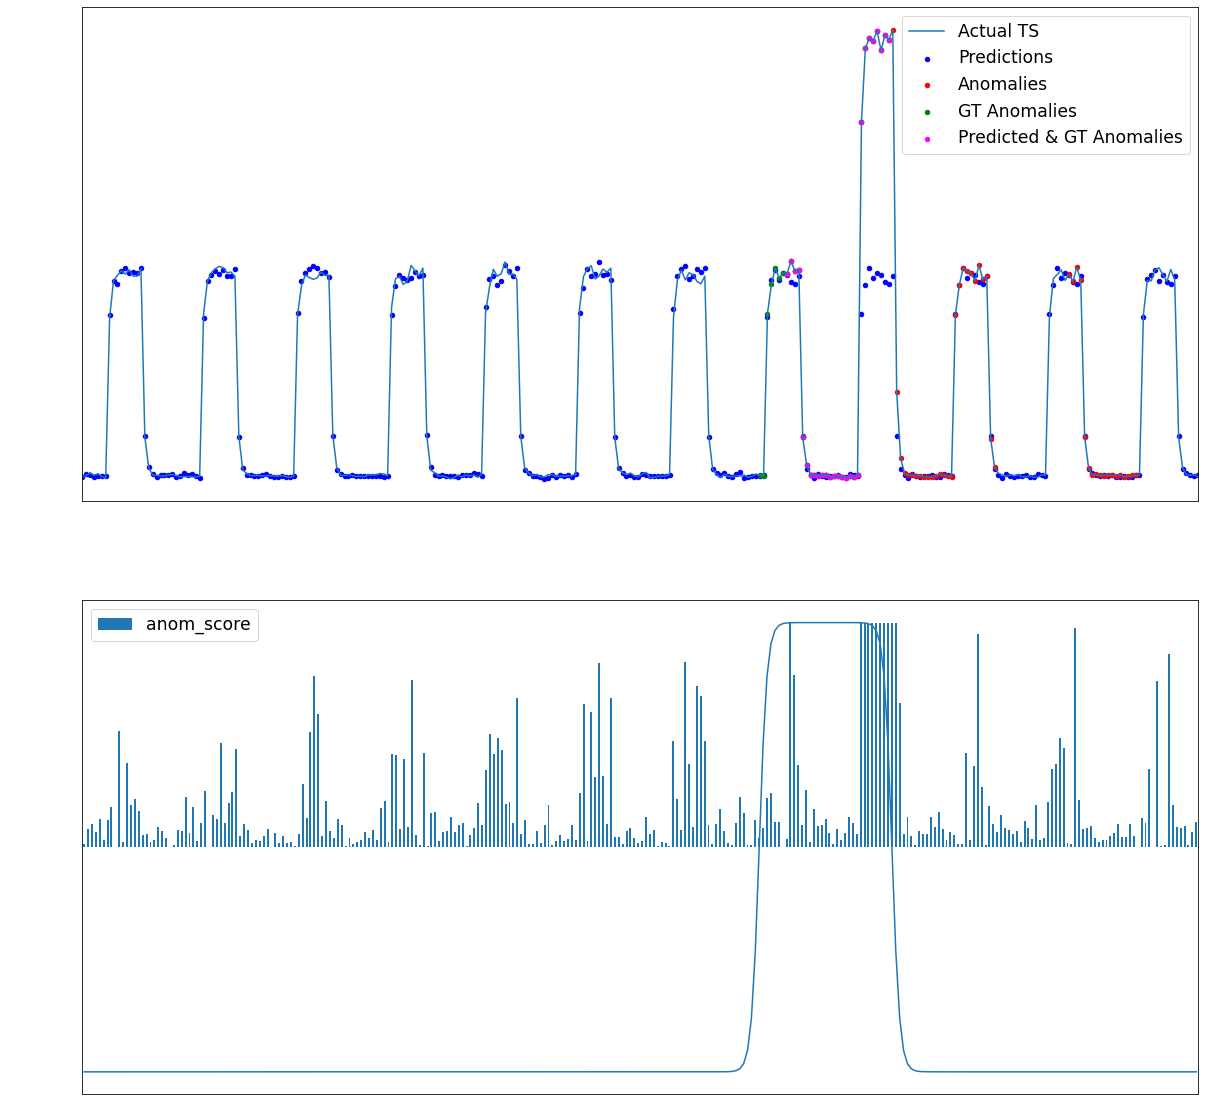

1st:  1.0
2nd:  0.8370580932487933
3rd:  0.8271209178535212
Customized score:  0.8880596703674382
1st:  1.0
2nd:  0.8370580932487933
3rd:  0.8271209178535212


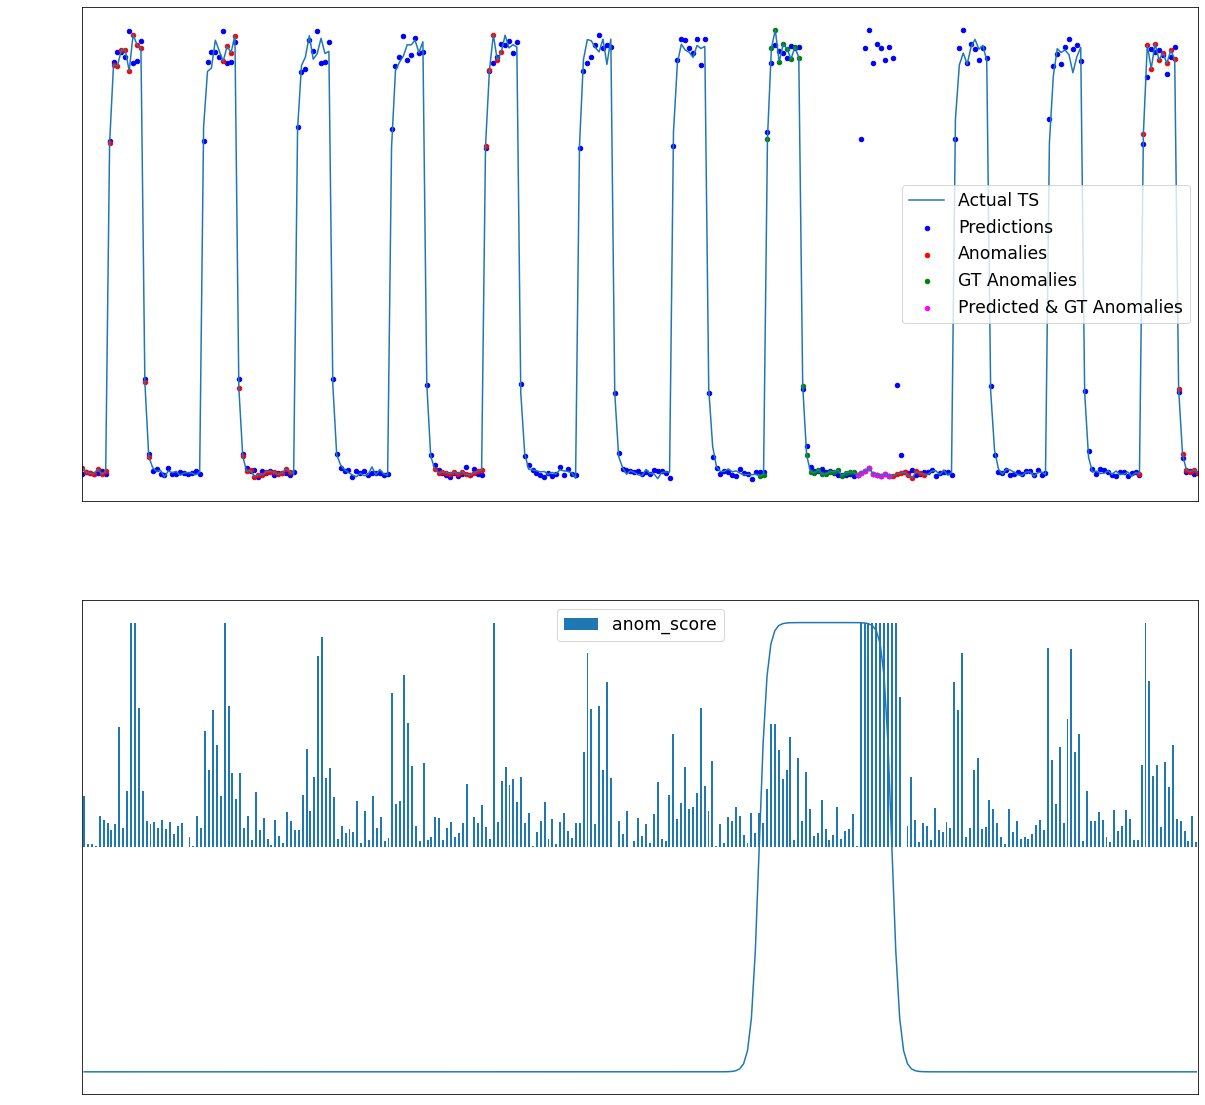

1st:  0.5294117647058824
2nd:  0.2591827023619956
3rd:  0.6906517286011413
Customized score:  0.4930820652230064
1st:  0.5294117647058824
2nd:  0.2591827023619956
3rd:  0.6906517286011413


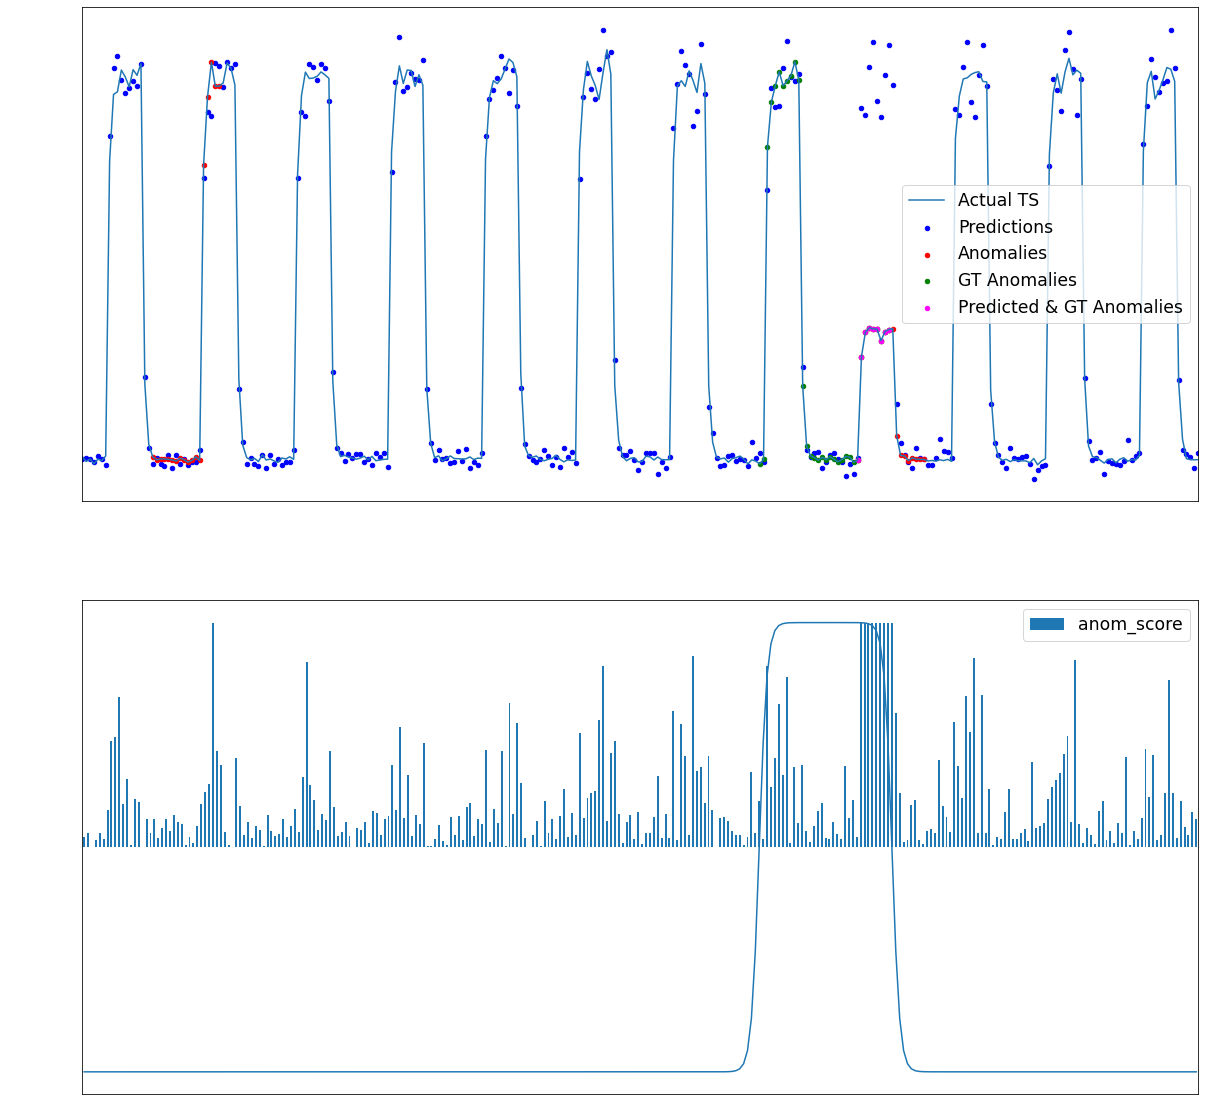

1st:  0.5294117647058824
2nd:  0.2591827023619956
3rd:  0.8993669154524829
Customized score:  0.5626537941734536
1st:  0.5294117647058824
2nd:  0.2591827023619956
3rd:  0.8993669154524829


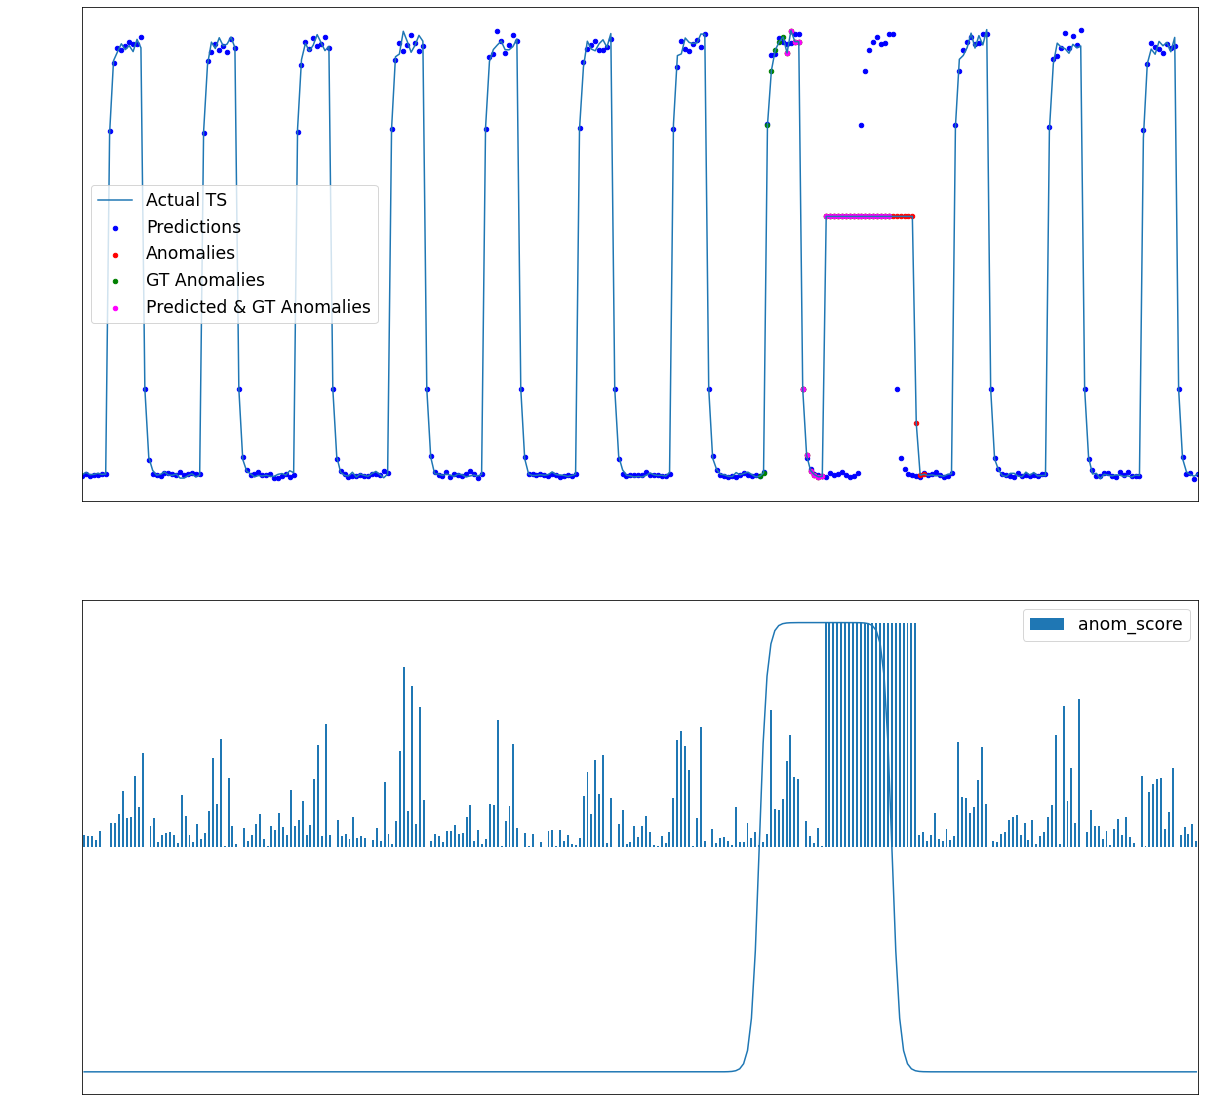

1st:  1.0
2nd:  0.8370580932487933
3rd:  0.9716144801317935
Customized score:  0.9362241911268624
1st:  1.0
2nd:  0.8370580932487933
3rd:  0.9716144801317935
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         Model: "sequential"

__________________________________________________________________________________________________________________________________

repeat_vector (RepeatVector) (None, 12, 128)           0         Layer (type)                 Output Shape              Param #   

_________________________________________________________________=================================================================

lstm_1 (LSTM)                (None, 12, 128)           131584    lstm (LSTM)

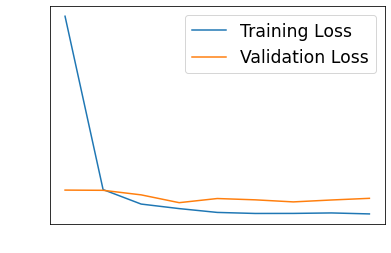

31/31 [==============================] 5/31 [===>..........................]17/31 [===============>..............] - ETA: 0s - loss: 0.0038 - ETA: 0s - loss: 0.0010 - ETA: 0s - loss: 0.003519/31 [=================>............] - ETA: 0s - loss: 0.0038 - ETA: 0s - loss: 0.0010 - ETA: 0s - loss: 0.0035 - ETA: 0s - loss: 0.0038 - ETA: 0s - loss: 9.9391e-04 - ETA: 0s - loss: 0.0034 - ETA: 0s - loss: 0.003825/31 [=======================>......]

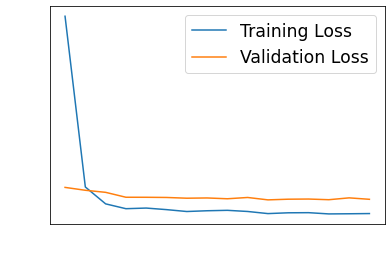

17/31 [===============>..............] - ETA: 0s - loss: 7.5142e-04 - ETA: 0s - loss: 0.003026/31 [========================>.....] - ETA: 0s - loss: 0.0030 - ETA: 0s - loss: 7.5664e-04 - ETA: 0s - loss: 7.6287e-04 - ETA: 0s - loss: 0.0030

<ipython-input-7-a43e8ffd5875>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return valid_err, results_df.loc[test_df.index & results_df.index]


31/31 [==============================] - ETA: 0s - loss: 0.0030 - ETA: 0s - loss: 7.7042e-04 - ETA: 0s - loss: 0.0030 - 1s 30ms/step - loss: 7.7242e-04 - val_loss: 0.0017
Epoch 18/50
31/31 [==============================] - ETA: 0s - loss: 0.0029 - ETA: 0s - loss: 3.7274e-04 - ETA: 0s - loss: 0.0029 - ETA: 0s - loss: 4.7372e-04 - ETA: 0s - loss: 0.0029 - ETA: 0s - loss: 4.6908e-04 - ETA: 0s - loss: 4.9562e-04

<ipython-input-7-a43e8ffd5875>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return valid_err, results_df.loc[test_df.index & results_df.index]


31/31 [==============================] - ETA: 0s - loss: 0.0021 - ETA: 0s - loss: 7.9660e-04 - ETA: 0s - loss: 0.0021 - ETA: 0s - loss: 7.7525e-04 - ETA: 0s - loss: 6.7002e-04 - 1s 28ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 24/50
31/31 [==============================] - ETA: 0s - loss: 0.0034 - ETA: 0s - loss: 6.6646e-04 - ETA: 0s - loss: 6.5970e-04 - ETA: 0s - loss: 0.0030 - ETA: 0s - loss: 6.6333e-04

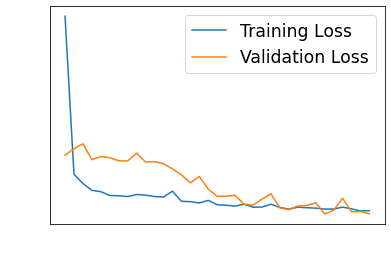

31/31 [==============================] - ETA: 0s - loss: 5.2263e-04 - ETA: 0s - loss: 5.1859e-04 - ETA: 0s - loss: 5.1486e-04 - 1s 25ms/step - loss: 5.1166e-04 - val_loss: 7.2338e-04
Epoch 38/50
13/31 [===========>..................] - ETA: 0s - loss: 5.0187e-04 - ETA: 0s - loss: 4.7478e-04 - ETA: 0s - loss: 4.4997e-04 - ETA: 0s - loss: 4.4795e-04 - ETA: 0s - loss: 4.5171e-04

/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/kad/models_evaluation/models_evaluator.py:79: RuntimeWarning: overflow encountered in exp
  new_scoring_func = 2 / (1 + np.exp(np.abs(total_index - absolute_anom_idx) - anom_idx_in_window)) - 1


31/31 [==============================] - ETA: 0s - loss: 4.5148e-04 - ETA: 0s - loss: 4.4779e-04 - ETA: 0s - loss: 4.4655e-04 - ETA: 0s - loss: 4.4435e-04 - ETA: 0s - loss: 4.4114e-04 - ETA: 0s - loss: 4.3922e-04 - ETA: 0s - loss: 4.3884e-04 - 1s 25ms/step - loss: 4.3873e-04 - val_loss: 4.7877e-04
Epoch 39/50
31/31 [==============================] - ETA: 0s - loss: 2.4500e-04 - ETA: 0s - loss: 2.9721e-04

<ipython-input-7-a43e8ffd5875>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return valid_err, results_df.loc[test_df.index & results_df.index]


31/31 [==============================] - ETA: 0s - loss: 4.5474e-04 - ETA: 0s - loss: 4.4969e-04 - ETA: 0s - loss: 4.4456e-04 - ETA: 0s - loss: 4.4015e-04

/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/kad/models_evaluation/models_evaluator.py:79: RuntimeWarning: overflow encountered in exp
  new_scoring_func = 2 / (1 + np.exp(np.abs(total_index - absolute_anom_idx) - anom_idx_in_window)) - 1


31/31 [==============================] - 1s 23ms/step - loss: 4.3893e-04 - val_loss: 3.7647e-04
Epoch 46/50
31/31 [==============================] - ETA: 0s - loss: 2.2941e-04 - ETA: 0s - loss: 3.2025e-04 - ETA: 0s - loss: 3.2304e-04 - ETA: 0s - loss: 3.1260e-04 - ETA: 0s - loss: 3.1838e-04 - ETA: 0s - loss: 3.1937e-04 - ETA: 0s - loss: 3.1820e-04 - ETA: 0s - loss: 3.1831e-04 - ETA: 0s - loss: 3.1803e-04

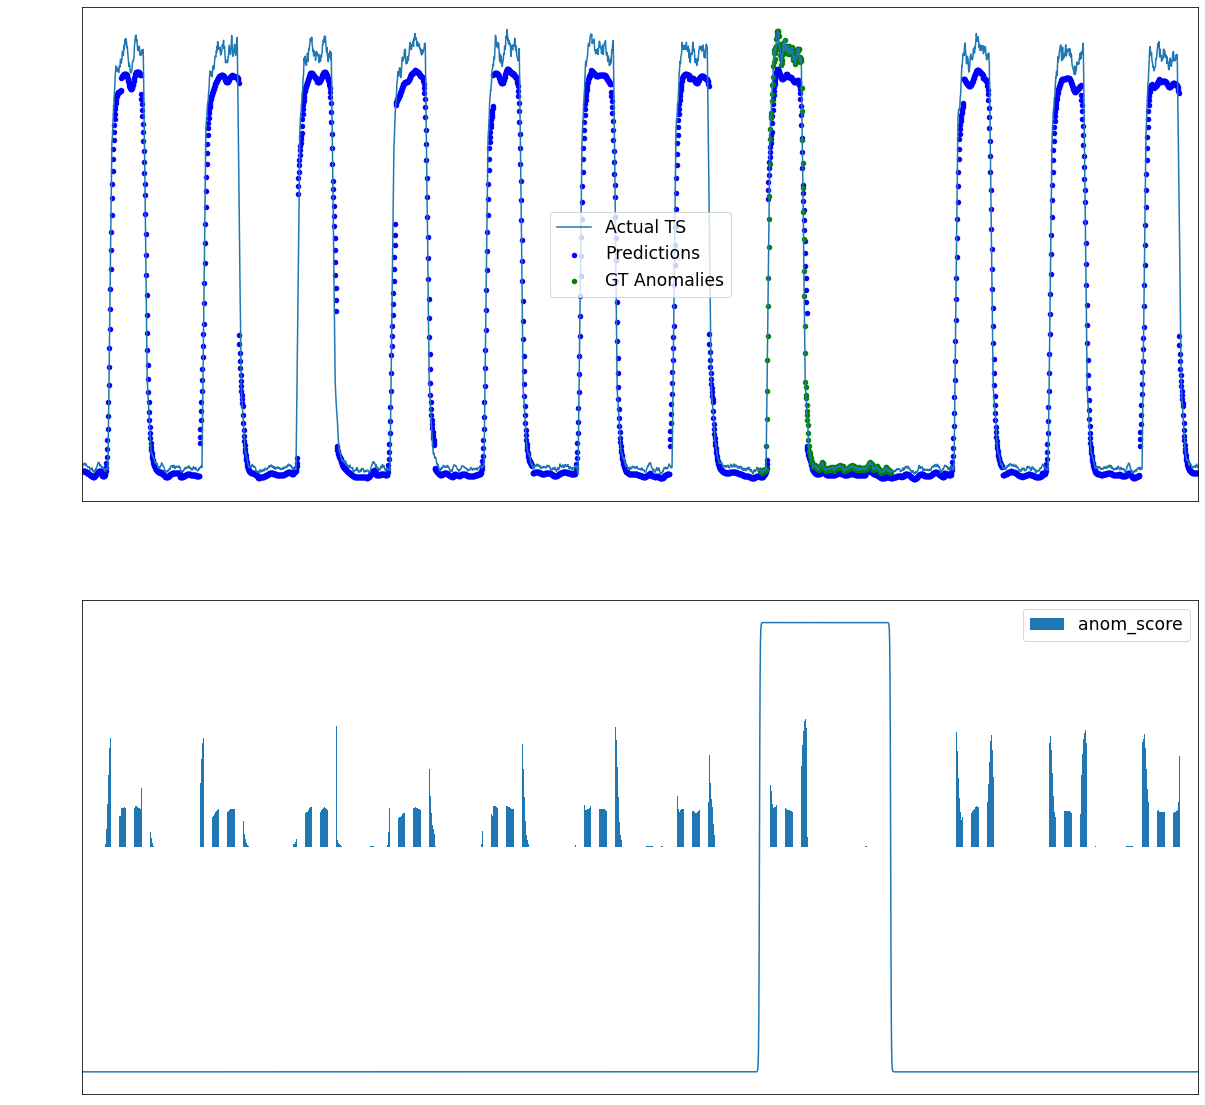

25/31 [=======================>......]1st:  - ETA: 0s - loss: 2.9818e-04 0.0
2nd:  0.0
3rd:  1.0
28/31 [==========================>...] - ETA: 0s - loss: 2.9631e-04Customized score:  0.3333333333333333
1st:  0.0
31/31 [==============================] - ETA: 0s - loss: 2.9586e-042nd:  0.0
3rd:  1.0
31/31 [==============================] - 1s 24ms/step - loss: 2.9572e-04 - val_loss: 3.4023e-04


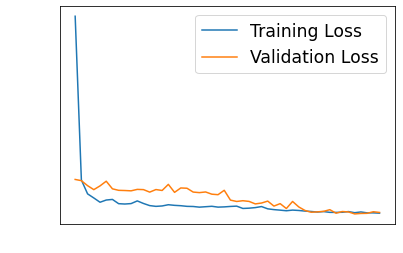

<ipython-input-8-51424b5678a1>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return valid_err, results_df.loc[test_df.index & results_df.index]


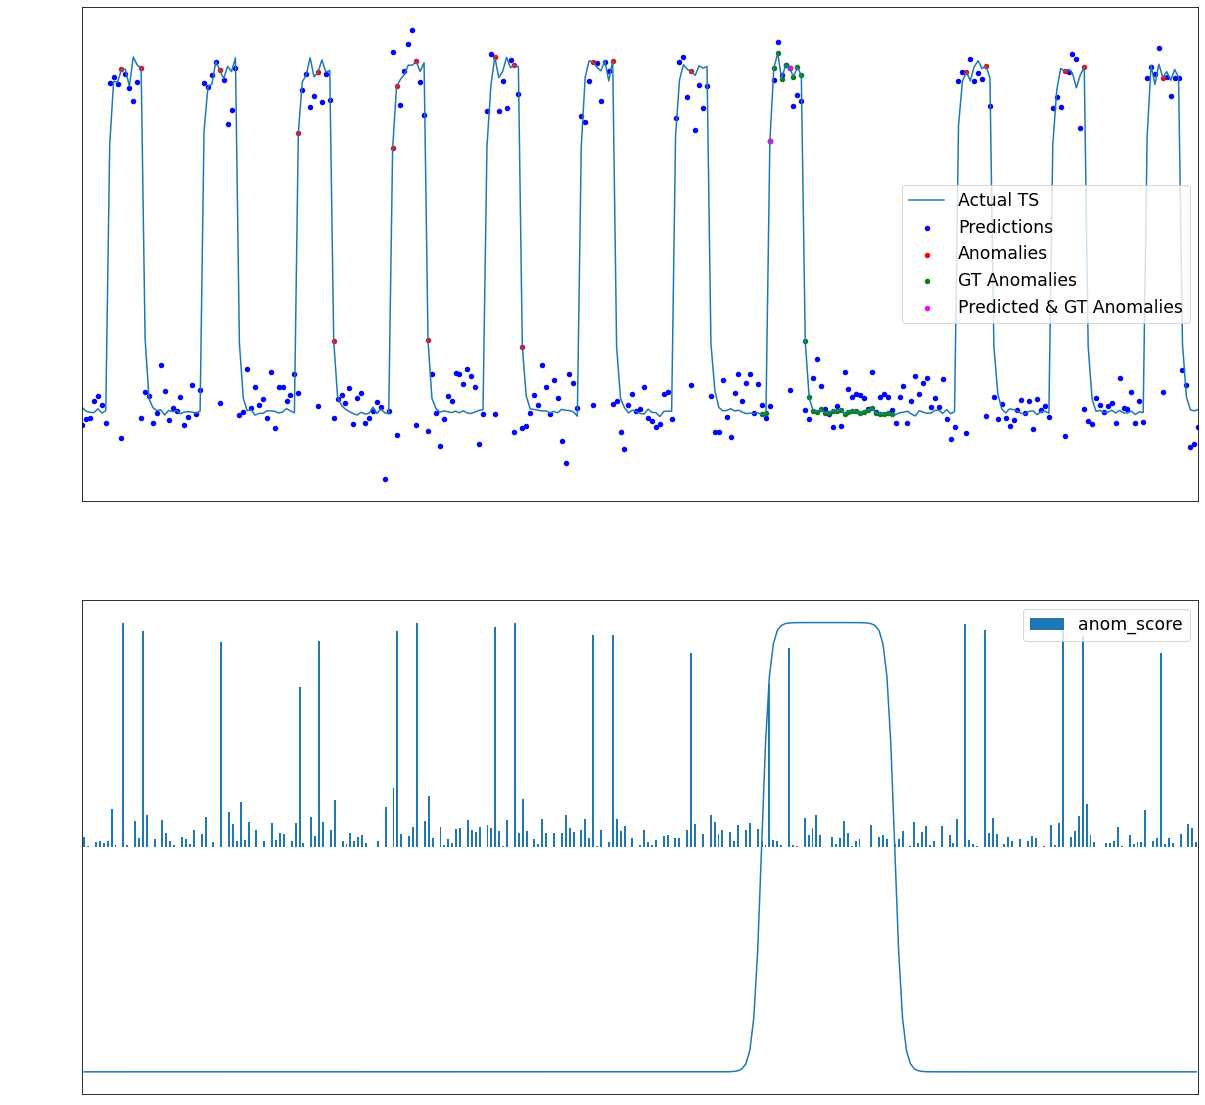

1st:  0.4117647058823529
2nd:  0.05650555489461886
3rd:  0.9153714968274416
Customized score:  0.4612139192014711
1st:  0.4117647058823529
2nd:  0.05650555489461886
3rd:  0.9153714968274416


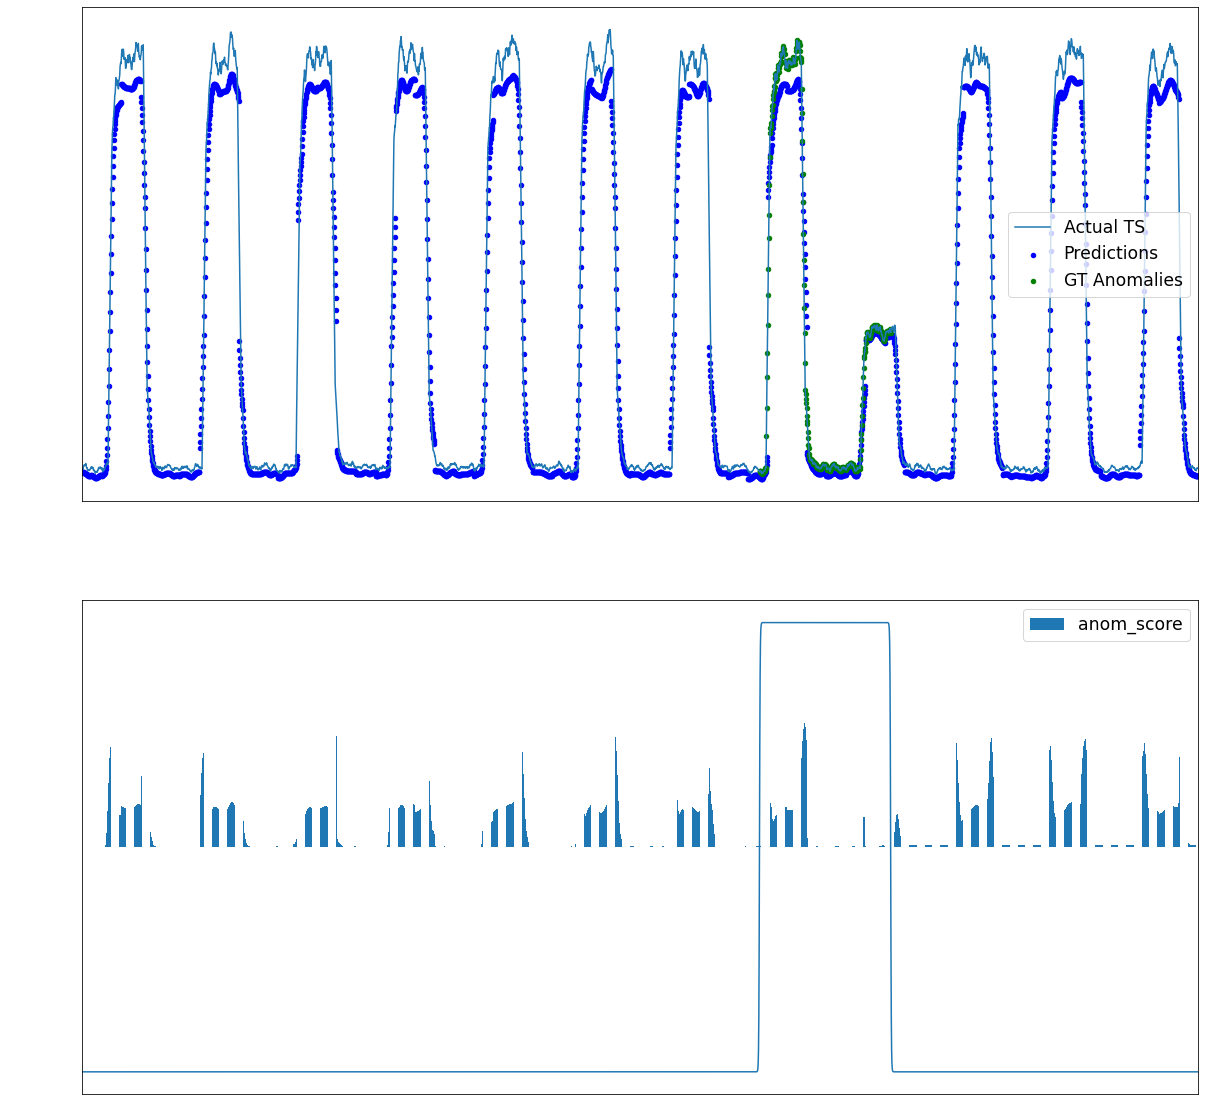

1st:  0.0
2nd:  0.0
3rd:  1.0
Customized score:  0.3333333333333333
1st:  0.0
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
2nd: ================================================================= 
0.0lstm_2 (LSTM)                (None, 12, 64)            16896     

_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        3rd:  
1.0=================================================================

Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


<ipython-input-7-a43e8ffd5875>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return valid_err, results_df.loc[test_df.index & results_df.index]
<ipython-input-8-51424b5678a1>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return valid_err, results_df.loc[test_df.index & results_df.index]


1/1 [==============================] - ETA: 0s - loss: 0.4815 - 3s 3s/step - loss: 0.4815 - val_loss: 0.1173
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 0.4680 - 0s 59ms/step - loss: 0.4680 - val_loss: 0.1155
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 0.4522 - 0s 70ms/step - loss: 0.4522 - val_loss: 0.1137
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 0.4394 - 0s 61ms/step - loss: 0.4394 - val_loss: 0.1119
Epoch 5/50
1/1 [==============================] - ETA: 0s - loss: 0.4213 - 0s 80ms/step - loss: 0.4213 - val_loss: 0.1103
Epoch 6/50
1/1 [==============================] - ETA: 0s - loss: 0.4042

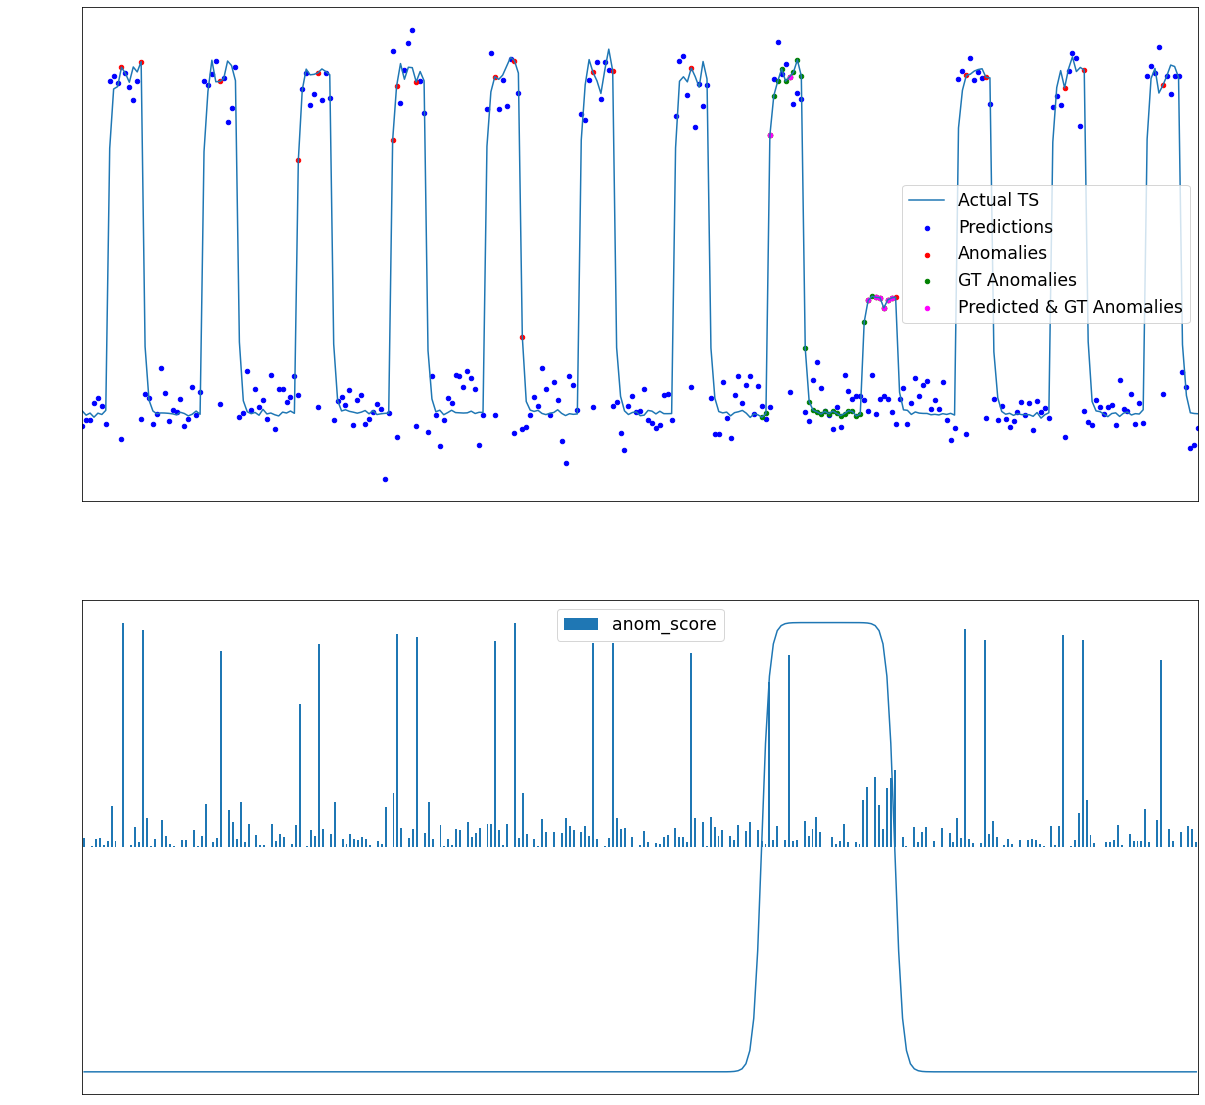

1st:  0.4117647058823529
2nd:  0.2195477445092283
3rd:  0.9234313542959072
Customized score:  0.5182479348958294
1st:  0.4117647058823529
2nd:  0.2195477445092283
3rd:  0.9234313542959072


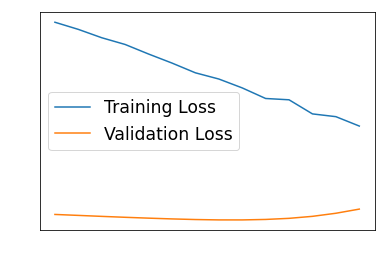

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


<ipython-input-9-fa95846602b9>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return valid_err, results_df.loc[test_df.index & results_df.index]
/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/kad/models_evaluation/models_evaluator.py:79: RuntimeWarning: overflow encountered in exp
  new_scoring_func = 2 / (1 + np.exp(np.abs(total_index - absolute_anom_idx) - anom_idx_in_window)) - 1


1/1 [==============================] - ETA: 0s - loss: 0.5124 - 2s 2s/step - loss: 0.5124 - val_loss: 0.1222
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 0.4930 - 0s 60ms/step - loss: 0.4930 - val_loss: 0.1204
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 0.4758 - 0s 64ms/step - loss: 0.4758 - val_loss: 0.1187
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 0.4511 - 0s 65ms/step - loss: 0.4511 - val_loss: 0.1171
Epoch 5/50
1/1 [==============================] - ETA: 0s - loss: 0.4470

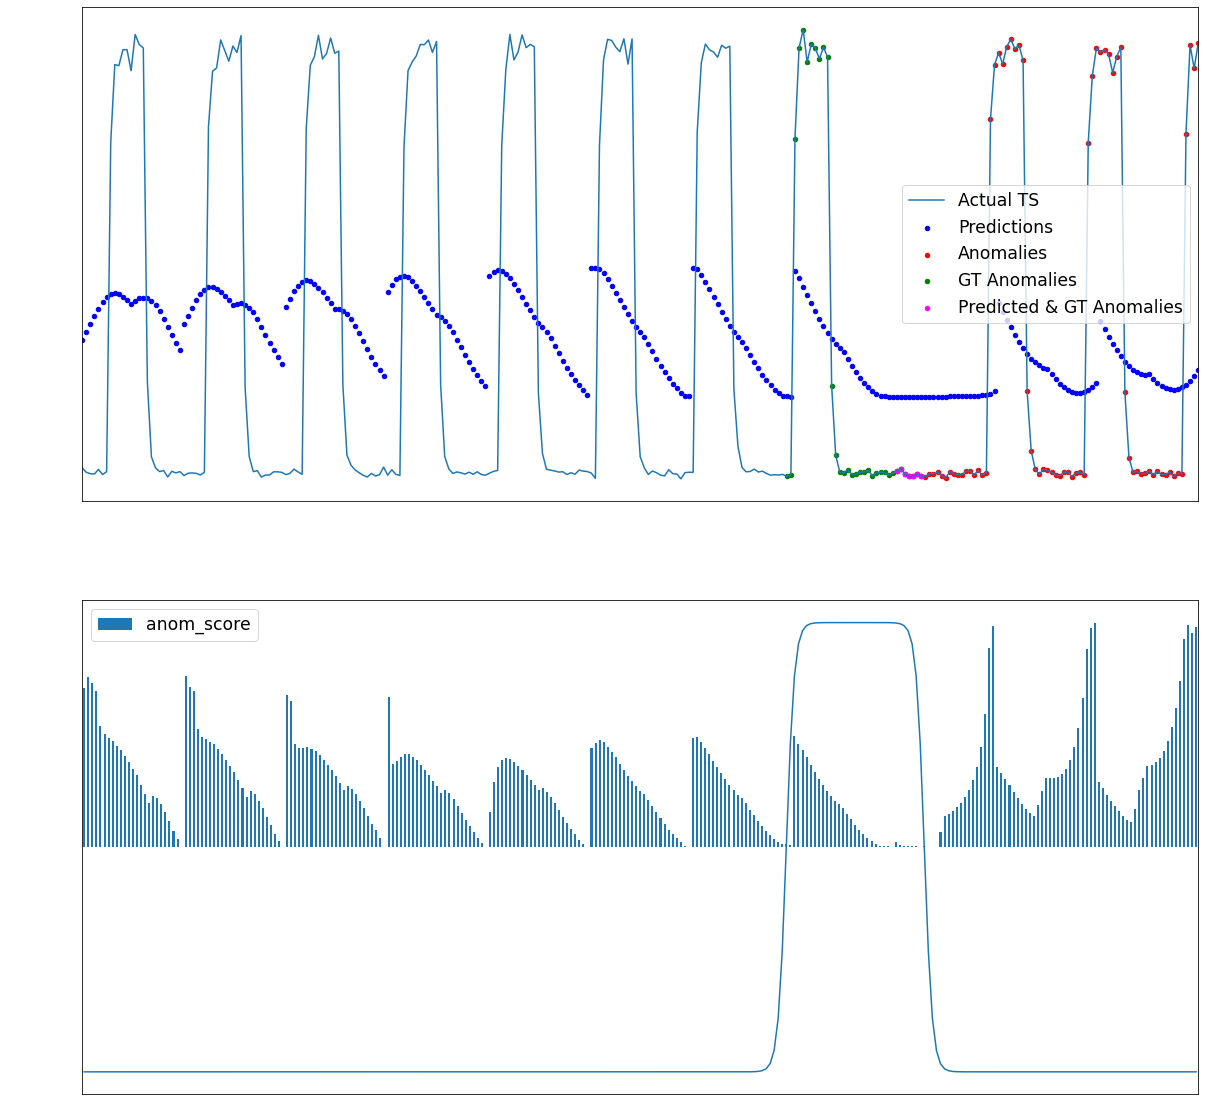

1st:  0.4117647058823529
2nd:  0.19499298738618995
3rd:  0.7225550321025178
Customized score:  0.4431042417903536
1st:  0.4117647058823529
2nd:  0.19499298738618995
3rd:  0.7225550321025178
1/1 [==============================] - 0s 88ms/step - loss: 0.4470 - val_loss: 0.1157
Epoch 6/50
1/1 [==============================] - ETA: 0s - loss: 0.4218 - 0s 68ms/step - loss: 0.4218 - val_loss: 0.1145
Epoch 7/50
1/1 [==============================] - ETA: 0s - loss: 0.3999 - 0s 61ms/step - loss: 0.3999 - val_loss: 0.1135
Epoch 8/50
1/1 [==============================] - ETA: 0s - loss: 0.4079 - 0s 70ms/step - loss: 0.4079 - val_loss: 0.1130
Epoch 9/50
1/1 [==============================] - ETA: 0s - loss: 0.3790 - 0s 61ms/step -

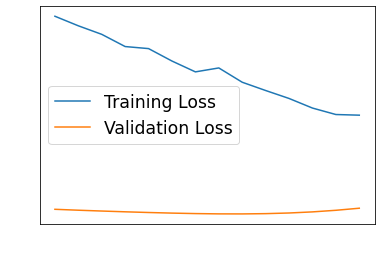

<ipython-input-9-fa95846602b9>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return valid_err, results_df.loc[test_df.index & results_df.index]


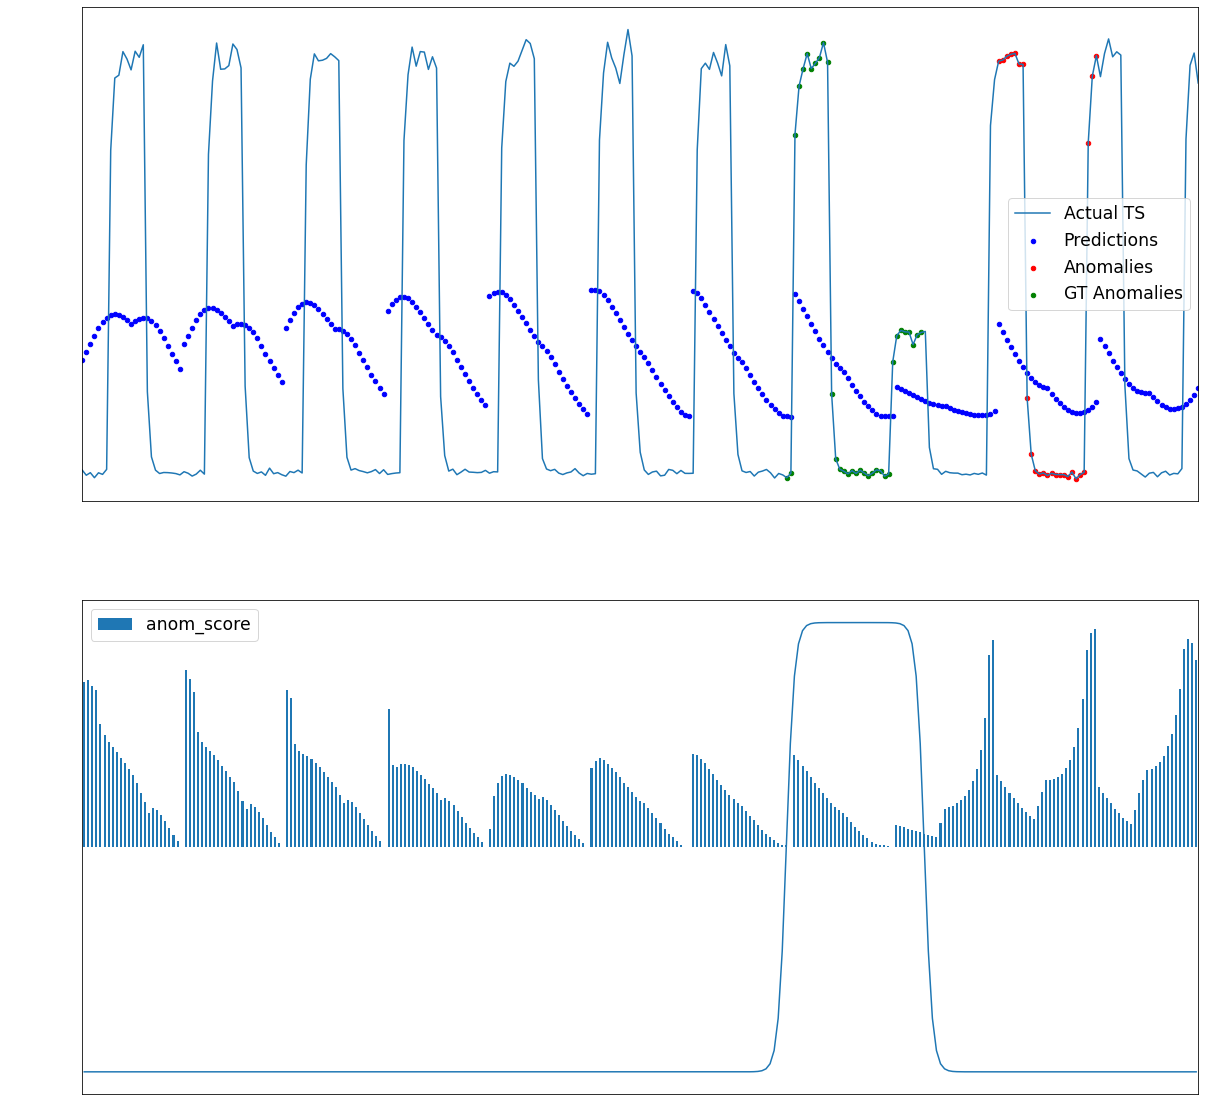

1st:  0.0
2nd:  0.0
3rd:  0.8950212114747416
Customized score:  0.29834040382491384
1st:  0.0
2nd:  0.0
3rd:  0.8950212114747416


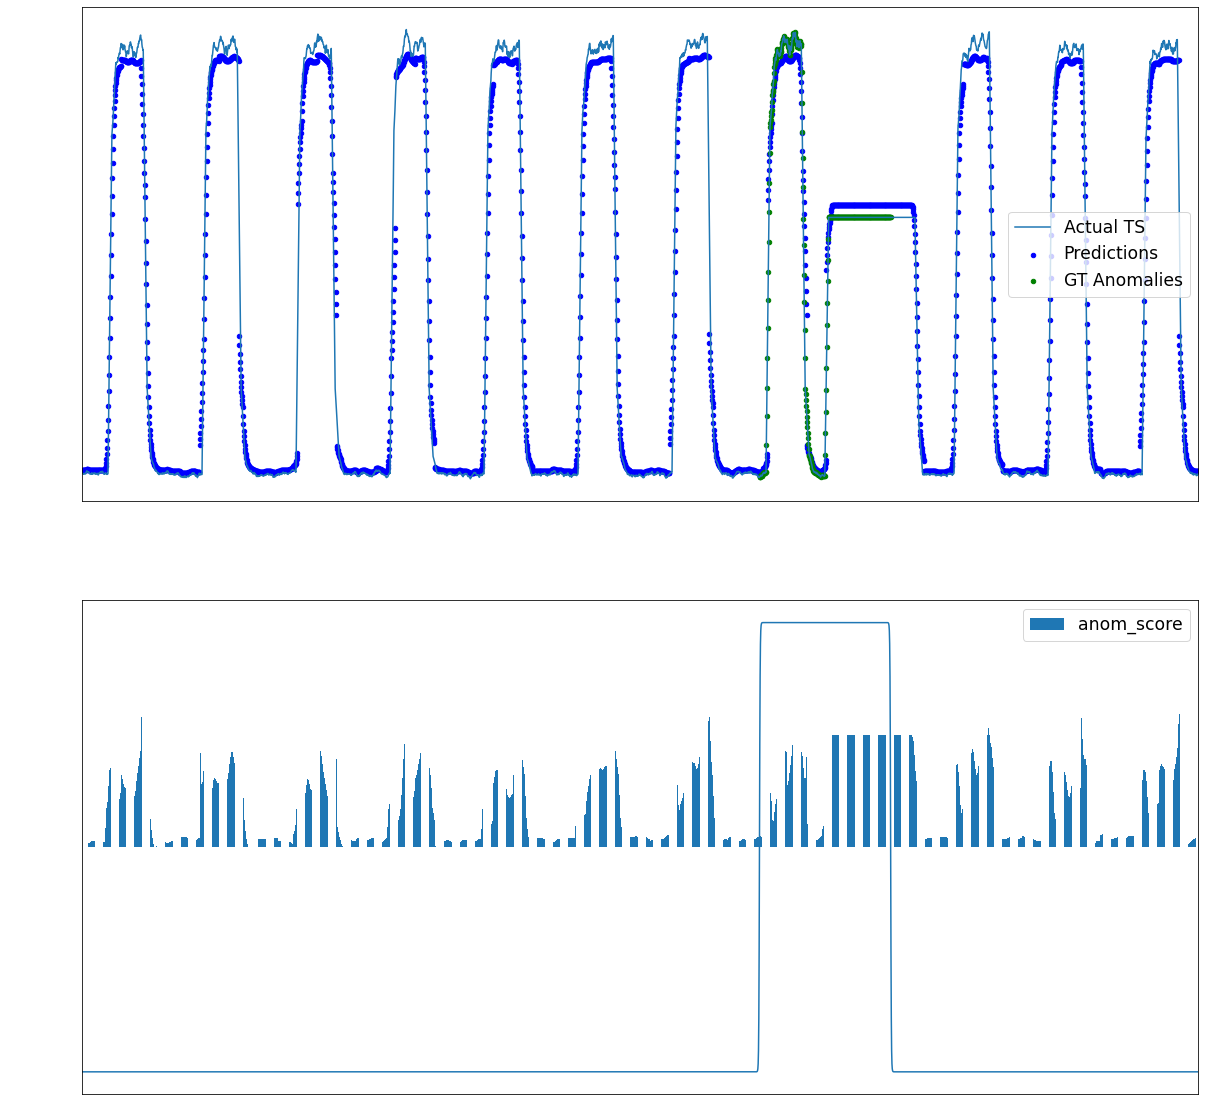

1st:  0.0
2nd:  0.0
3rd:  1.0
Customized score:  0.3333333333333333
1st:  0.0
2nd:  0.0
3rd:  1.0


<ipython-input-8-51424b5678a1>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return valid_err, results_df.loc[test_df.index & results_df.index]
/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/kad/models_evaluation/models_evaluator.py:79: RuntimeWarning: overflow encountered in exp
  new_scoring_func = 2 / (1 + np.exp(np.abs(total_index - absolute_anom_idx) - anom_idx_in_window)) - 1


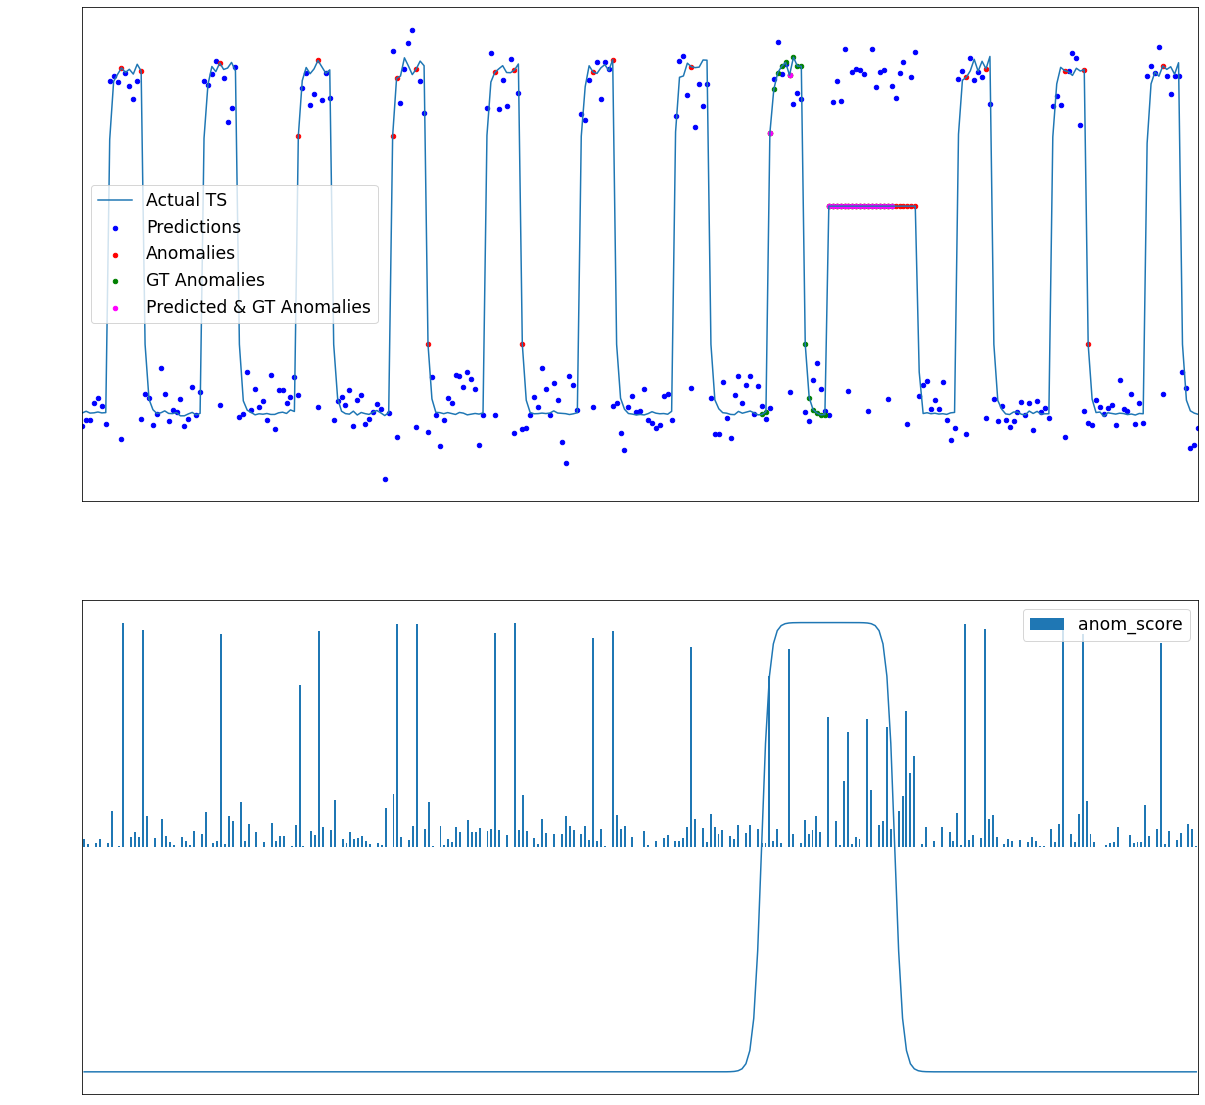

1st:  1.0
2nd:  0.5725603473609202
3rd:  0.8989313967325377
Customized score:  0.823830581364486
1st:  1.0
2nd:  0.5725603473609202
3rd:  0.8989313967325377
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 0.5749

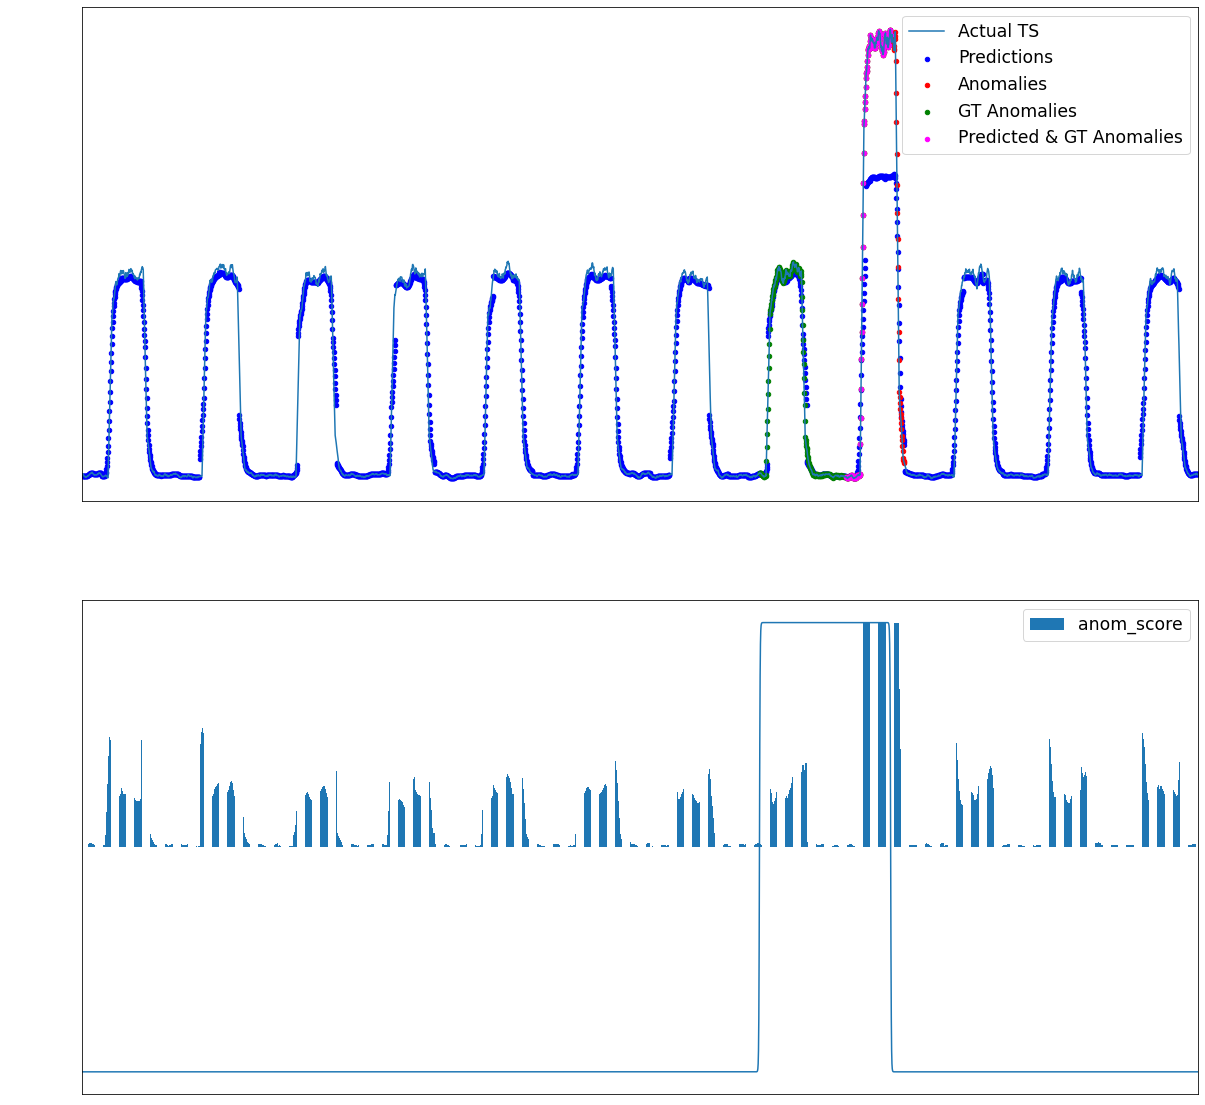

1st:  0.681592039800995
1/1 [==============================]2nd:  - 0s 55ms/step - loss: 0.3827 - val_loss: 0.1094
 Epoch 13/500.3409092857330762

1/1 [==============================] - ETA: 0s - loss: 0.36643rd:  0.9863782022092503
Customized score:  0.6696265092477739
1st:  0.681592039800995
2nd:  0.3409092857330762
1/1 [==============================] - 0s 59ms/step - loss: 0.3664 - val_loss: 0.1106
Epoch 14/50
3rd:  0.9863782022092503
1/1 [==============================] - ETA: 0s - loss: 0.3535 - 0s 51ms/step - loss: 0.3535 - val_loss: 0.1130
Epoch 15/50
1/1 [==============================] - ETA: 0s - loss: 0.3288 - 0s 51ms/step - loss: 0.3288 - val_loss: 0.1167
Epoch 16/50
1/1 [==============================] - ETA: 0s - loss: 0.3260 - 0s 60ms/step -

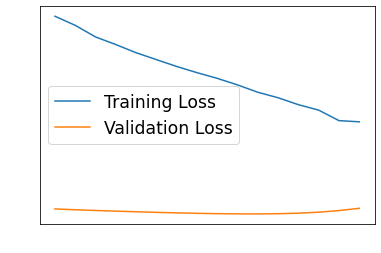

<ipython-input-8-51424b5678a1>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return valid_err, results_df.loc[test_df.index & results_df.index]
<ipython-input-9-fa95846602b9>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return valid_err, results_df.loc[test_df.index & results_df.index]


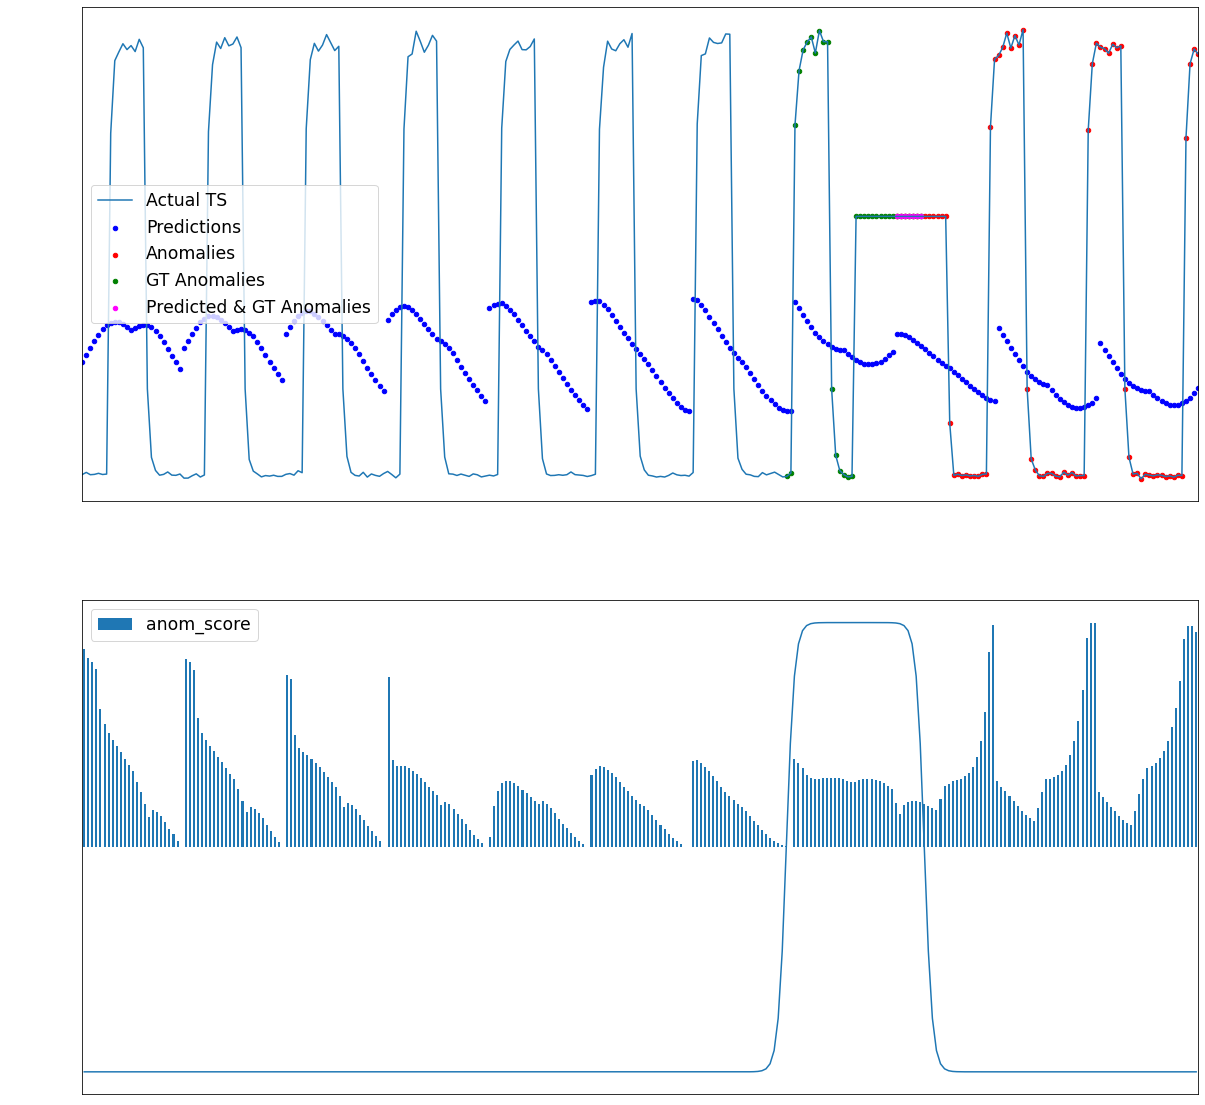

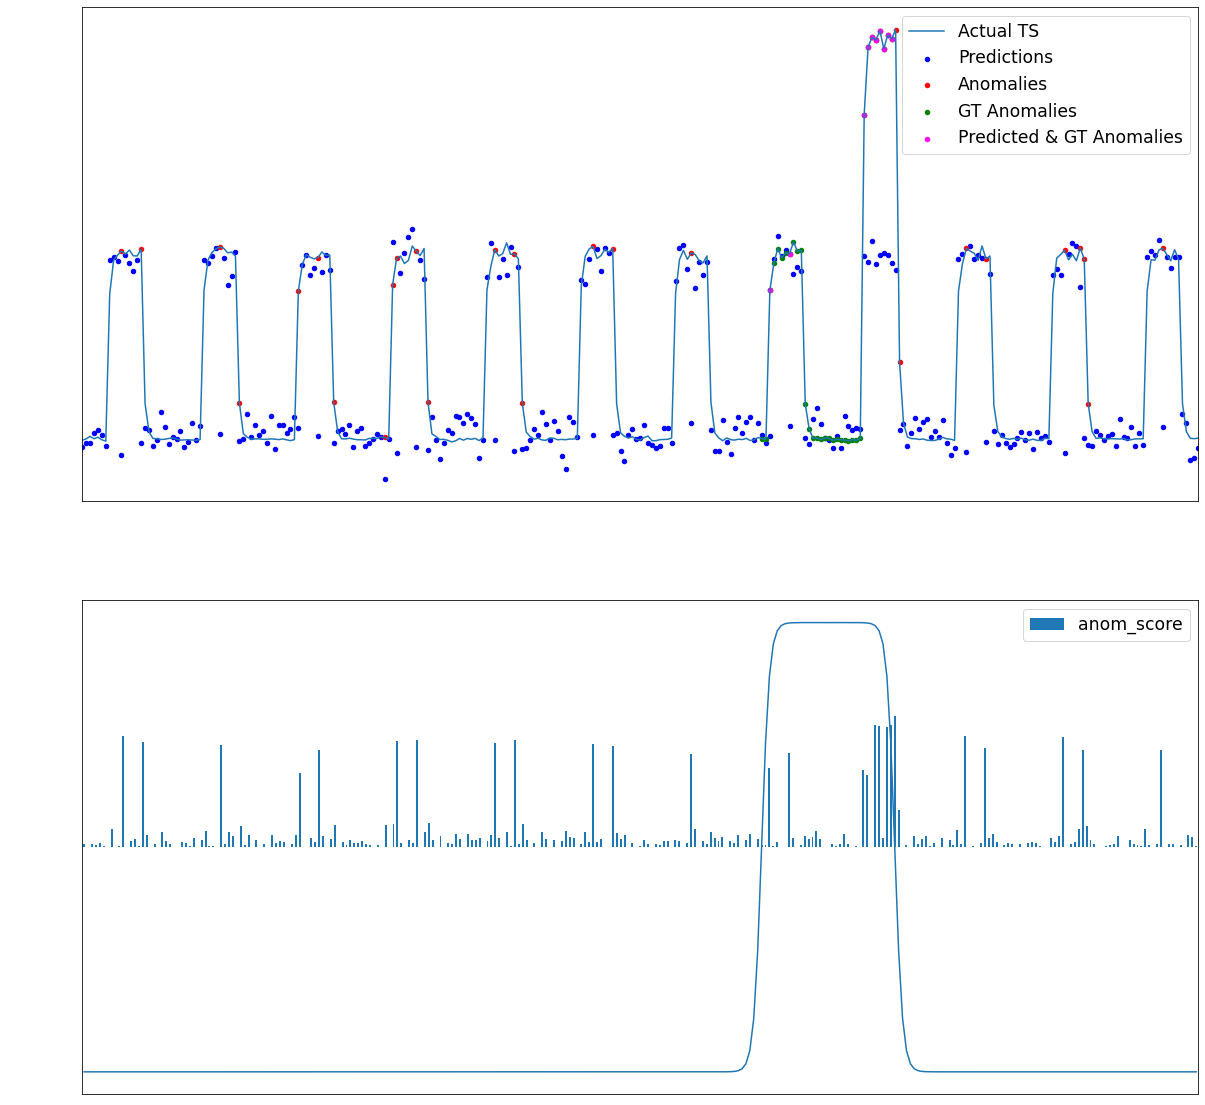

1st: 1st:   0.47058823529411764
0.4117647058823529
2nd:  2nd: 0.2835865939632696 
0.19499298738618995
3rd: 3rd:   0.89738948267988640.7225550321025178

Customized score:  0.4431042417903536Customized score: 
 0.5505214373124245
1st:  0.4117647058823529
1st:  2nd: 0.47058823529411764 
0.19499298738618995
3rd: 2nd:   0.72255503210251780.2835865939632696

3rd:  0.8973894826798864
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Tota

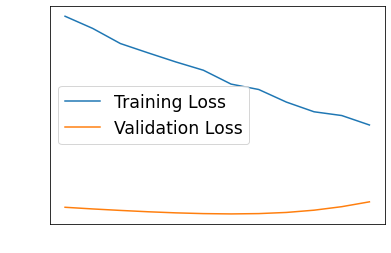

<ipython-input-9-fa95846602b9>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return valid_err, results_df.loc[test_df.index & results_df.index]


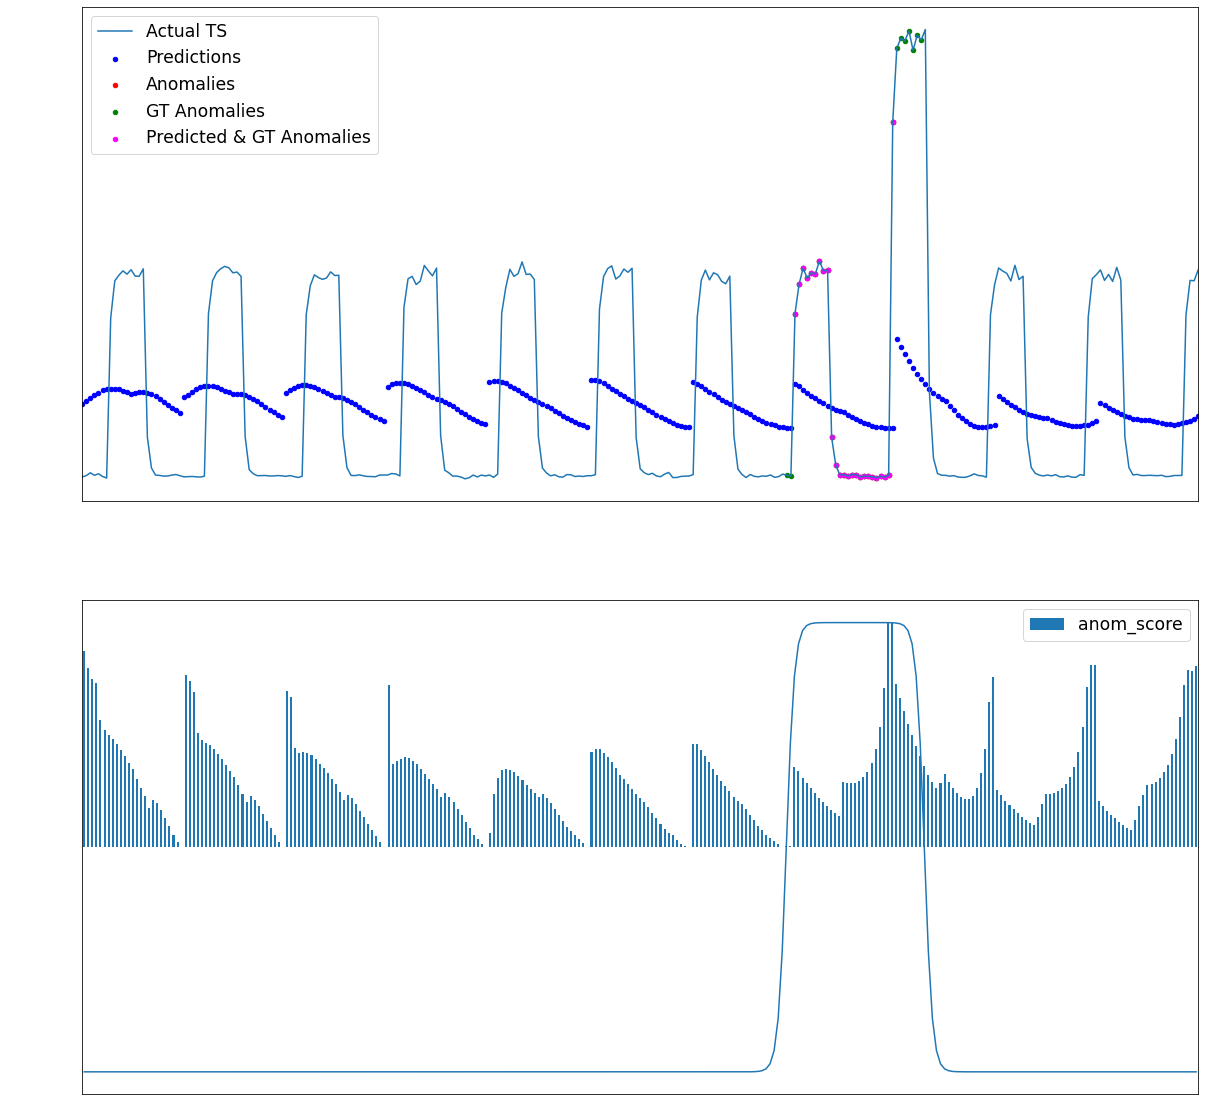

1st:  1.0
2nd:  0.7901686212753565
3rd:  1.0
Customized score:  0.9300562070917855
1st:  1.0
2nd:  0.7901686212753565
3rd:  1.0


In [10]:
from typing import Tuple
import concurrent

eval_dict: dict = {}

X_LABEL = "timestamp"
data_dir = "data/archive/"
file_dir = "artificialWithAnomaly"

with open("data/archive/combined_windows.json") as f:
    ground_true_anomalies = json.load(f)

executor = concurrent.futures.ProcessPoolExecutor()


def task_executor(filename: str, original_df: pd.DataFrame, ground_true_anomalies: dict, eval_func):
    file_eval_dict = {}

    true_anomalies_ranges = ground_true_anomalies["/".join(file_path.split("/")[-2:])]
    ground_true_anomalies_df = pd.DataFrame()
    for anom_range in true_anomalies_ranges:
        ground_true_anomalies_df = ground_true_anomalies_df.append(
            original_df.loc[anom_range[0]:anom_range[1]])
    original_df[kad_utils.GROUND_TRUTH_COLUMN] = [idx in ground_true_anomalies_df.index for idx in
                                                  original_df.index.tolist()]

    # SARIMA
    preprocessed_df = original_df.groupby(pd.Grouper(freq="h")).apply(downsampling_func)
    scaler = MinMaxScaler(feature_range=(0, 1))
    preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

    file_eval_dict[SARIMA_KEY] = []
    sarima_valid_err, sarima_eval_df = evaluate_sarima(preprocessed_df)
    file_eval_dict[SARIMA_KEY].append(eval_func(sarima_valid_err, sarima_eval_df))

    # AUTOENCODER
    preprocessed_df = original_df.copy()
    preprocessed_df["value"] = preprocessed_df["value"].rolling("h").sum()
    scaler = MinMaxScaler(feature_range=(0, 1))
    preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

    file_eval_dict[AUTOENCODER_KEY] = []
    autoenc_valid_err, autoenc_eval_df = evaluate_autoencoder(preprocessed_df)
    file_eval_dict[AUTOENCODER_KEY].append(eval_func(autoenc_valid_err, autoenc_eval_df))

    # HMM
    preprocessed_df = original_df.groupby(pd.Grouper(freq="h")).apply(downsampling_func)
    scaler = MinMaxScaler(feature_range=(0, 1))
    preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

    file_eval_dict[HMM_KEY] = []
    hmm_valid_err, hmm_eval_df = evaluate_hmm(preprocessed_df)
    file_eval_dict[HMM_KEY].append(eval_func(hmm_valid_err, hmm_eval_df))

    # LSTM
    preprocessed_df = original_df.groupby(pd.Grouper(freq="h")).apply(downsampling_func)
    scaler = MinMaxScaler(feature_range=(0, 1))
    preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

    file_eval_dict[LSTM_KEY] = []
    lstm_valid_err, lstm_eval_df = evaluate_lstm(preprocessed_df)
    file_eval_dict[LSTM_KEY].append(eval_func(lstm_valid_err, lstm_eval_df))

    return filename, file_eval_dict


files_to_eval = ["art_daily_flatmiddle.csv",
                 "art_daily_jumpsdown.csv",
                 "art_daily_nojump.csv",
                 "art_daily_jumpsup.csv"]

futures_table = list()

for (dirpath, dirnames, filenames) in os.walk(data_dir):
    for filename in filenames:
        if filename in files_to_eval:
            file_path = os.path.join(dirpath, filename)
            original_df = pd.read_csv(file_path, parse_dates=True, index_col="timestamp")
            print("after reading csv")
            futures_table.append(
                executor.submit(task_executor, filename, original_df, ground_true_anomalies,
                                perform_customized_evaluation))

for future in futures_table:
    result: Tuple[str, dict] = future.result()
    eval_dict[result[0]] = result[1]

In [11]:
eval_json = "eval.json"

with open(eval_json, "w") as fp:
    json.dump(eval_dict, fp)

In [13]:
eval_dict

{'art_daily_flatmiddle.csv': {'SARIMA': [{'total': 0.9362241911268624,
    'accuracy component': 1.0,
    'collective component': 0.8370580932487933,
    'precision component': 0.9716144801317935}],
  'autoencoder': [{'total': 0.3333333333333333,
    'accuracy component': 0.0,
    'collective component': 0.0,
    'precision component': 1.0}],
  'HMM': [{'total': 0.823830581364486,
    'accuracy component': 1.0,
    'collective component': 0.5725603473609202,
    'precision component': 0.8989313967325377}],
  'LSTM': [{'total': 0.4431042417903536,
    'accuracy component': 0.4117647058823529,
    'collective component': 0.19499298738618995,
    'precision component': 0.7225550321025178}]},
 'art_daily_jumpsdown.csv': {'SARIMA': [{'total': 0.5626537941734536,
    'accuracy component': 0.5294117647058824,
    'collective component': 0.2591827023619956,
    'precision component': 0.8993669154524829}],
  'autoencoder': [{'total': 0.3333333333333333,
    'accuracy component': 0.0,
    'colle